# A Guide to Transfer Learning with TensorFlow

This notebook will prepare an image dataset and then run comparisons of various TensorFlow models as follows:

1. Model 1 - A simple Conv2D based model
2. Model 2 - EfficientNet with random weight initialization
3. Model 3 - EfficientNet with ImageNet weight initialization and EfficientNet layers locked
4. Model 4 - EfficientNet with ImageNet weight initialization and fine tuning


## Initialization

In [1]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.0 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Sun May 21 17:43:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import random
import requests 
import py7zr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

In [4]:
# check GPU is working
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# set random seed
SEED = 12
tf.keras.utils.set_random_seed(SEED)

## Define functions for later in the notebook

In [6]:
# function for downloading the image files from a URL
def download_file(url, filename, chunk_size=128):
    response = requests.get(url, stream=True)
    with open(f'./{filename}', 'wb') as new_file:
        for chunk in response.iter_content(chunk_size=chunk_size):
            new_file.write(chunk)

# plot an image
def plot_example_image(target_class):
  
  # target directory
  target_folder = f'rps/{target_class}'

  # random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # plot image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(f"Class: {target_class}")
  plt.axis("off")

  print(f"Type: {type(img)}")
  print(f"Shape: {img.shape}")
  print(f"Colour channels: {img.shape[2]}")
  print(f"Size: {img.size / 1000}KB")
  print(f"Max value: {img.max()}")
  print(f"Min value: {img.min()}")
  print(f"Image name: {random_image[0]}")

  return img

# plot loss and accuracy on a graph
def plot_loss_acc(history, model_name):

    # prepare data
    history = history.history
    epochs = range(1,len(history['loss'])+1, 1)

    # set general figure 
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(7,9), dpi=100)
    fig.suptitle(f"{model_name}", fontsize=16)
    fig.tight_layout()
    
    # assign data to plots
    sns.lineplot(x = epochs, y = 'accuracy', data = history, ax=axes[0], label='Accuracy')
    sns.lineplot(x = epochs, y = 'val_accuracy', data = history, ax=axes[0], label='Validation Accuracy')
    sns.lineplot(x = epochs, y = 'loss', data = history, ax=axes[1], label='Loss')
    sns.lineplot(x = epochs, y = 'val_loss', data = history, ax=axes[1], label='Validation Loss')
    
    # set axis limits and ticks
    plt.xlim([1, 15])
    plt.xticks(epochs)
    axes[0].set_ylim([None, 1])

    # show grid
    axes[0].grid()
    axes[1].grid()

    # set axis labels
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("Loss")
    plt.xlabel("Epochs")

    # assign legend location
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='upper right')
    
    plt.show()

# combine two sets of histories together ready for plotting
def combine_histories(history1, history2):
    
    history1.history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy'] 
    history1.history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy'] 
    history1.history['loss'] = history1.history['loss'] + history2.history['loss'] 
    history1.history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss'] 

    return history1

## Download and extract images

In [7]:
# define folders and filenames
dl_file_1 = 'rps.7z.001'
dl_file_2 = 'rps.7z.002'
filenames = [dl_file_1, dl_file_2]
output_file = 'rps.7z'
root_folder = './rps'
file_part1 = 'https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors_712.7z.001'
file_part2 = 'https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors_712.7z.002'

In [8]:
# download files
download_file(url=file_part1, filename=dl_file_1)
download_file(url=file_part2, filename=dl_file_2)

In [9]:
# concatenate files
with open(output_file, 'ab') as outfile: 
    for filename in filenames:
        with open(filename, 'rb') as infile:      
            outfile.write(infile.read())

# unzip concatenated file
with py7zr.SevenZipFile("rps.7z", "r") as archive:
    archive.extractall(path=root_folder)

# tidy up - delete archives
for f in filenames:
    os.remove(f)
os.remove(output_file)

## Check the extracted data

In [10]:
# print files and folders
for root, dirs, files in os.walk(root_folder):
    print(f"{len(dirs)} directories and {len(files)} files in '{root}'")

3 directories and 0 files in './rps'
0 directories and 712 files in './rps/paper'
0 directories and 712 files in './rps/rock'
0 directories and 712 files in './rps/scissors'


## Plot an example from each class

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.9019607901573181
Min value: 0.0
Image name: nsnqe5yD6JgUs9Bx.png


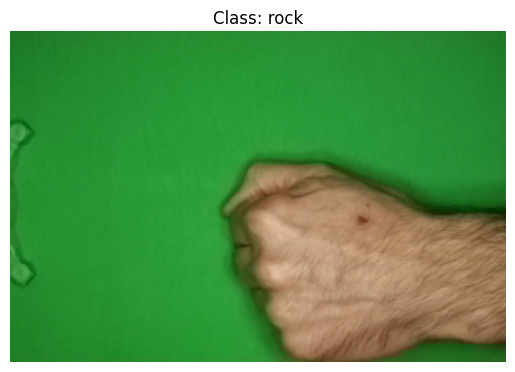

In [11]:
# View an image
img = plot_example_image("rock"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.9411764740943909
Min value: 0.0
Image name: BI9YnLkJ5wFZe6w8.png


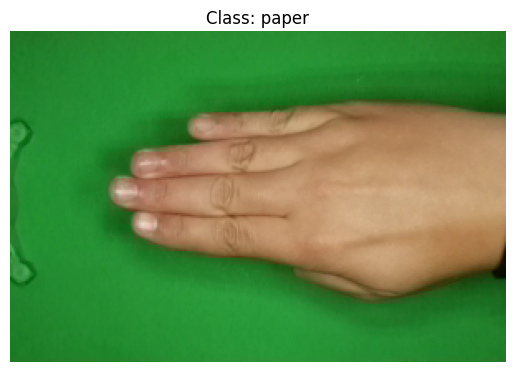

In [12]:
img = plot_example_image("paper"); 

Type: <class 'numpy.ndarray'>
Shape: (200, 300, 3)
Colour channels: 3
Size: 180.0KB
Max value: 0.9411764740943909
Min value: 0.0
Image name: QjvKDUTFuGf7gAm4.png


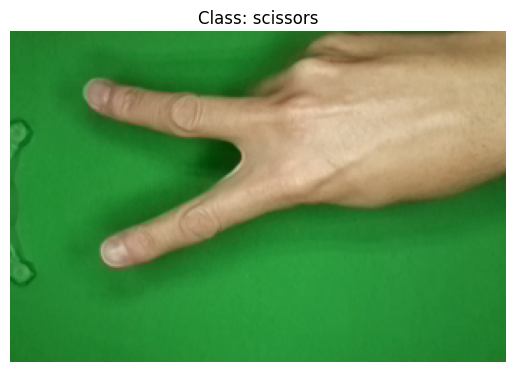

In [13]:
img = plot_example_image("scissors"); 

## Prepare data

In [14]:
# Constants
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
BATCH_SIZE = 32
DATA_DIR = f"{root_folder}/"

In [15]:
train_data, val_data = tf.keras.utils.image_dataset_from_directory(DATA_DIR, 
                                                                   labels='inferred',
                                                                   label_mode='categorical',
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMAGE_SIZE,
                                                                   shuffle=True, 
                                                                   seed=SEED,
                                                                   validation_split=0.5,
                                                                   subset='both')                        

Found 2136 files belonging to 3 classes.
Using 1068 files for training.
Using 1068 files for validation.


In [16]:
# get the class names generated from the dataset
class_names = train_data.class_names
num_classes = len(class_names)
class_names

['paper', 'rock', 'scissors']

## Plot Example data from all classes

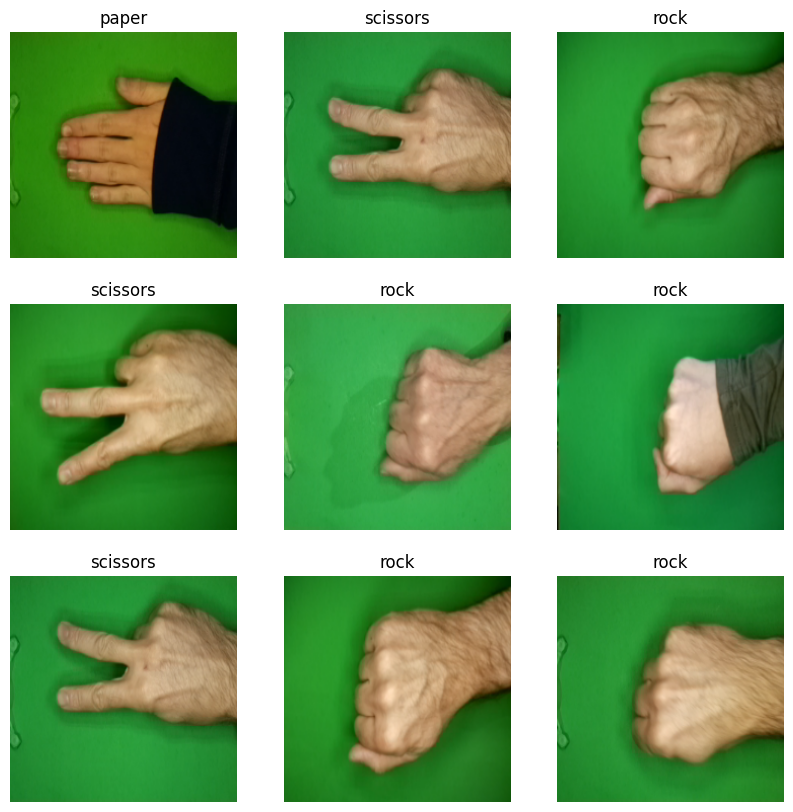

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.math.argmax(labels[i])])
    plt.axis("off")

## Data augmentation

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
# augment the image files
# the image files are PNG, and therefore already sit beween 0 and 1.
# typically a rescaling layer would be required if they were JPG
# however EfficientNet has an inbuilt scaling layer so even then it isn't required

data_augmentation = Sequential([
                                layers.RandomRotation(0.2),
                                layers.RandomFlip('horizontal'),
                                layers.RandomZoom(0.2)
], name='data_augmentation')

## Configure Datasets

In [20]:
train_data, val_data

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

In [21]:
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_data, val_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

## Create Models

1. Model 1 - A simple Conv2D based model
2. Model 2 - EfficientNet with random weight initialization
3. Model 3 - EfficientNet with ImageNet weight initialization and ImageNet layers locked
4. Model 4 - EfficientNet with ImageNet weight initialization and fine tuning

### Model 1: A simple Conv2D based model

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, Flatten

hidden_layers = Sequential([
                            Conv2D(filters=32,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            Conv2D(filters=64,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            Conv2D(filters=64,kernel_size=(3,3), padding='same', kernel_initializer='glorot_uniform', activation='selu'),
                            MaxPool2D(pool_size=(2,2)),
                            GlobalAveragePooling2D(name="global_pool_2D"),
                            Dense(64, kernel_initializer='glorot_uniform', activation='selu'),
], name='conv_network')

mod_1_inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name='mod_1_input_layer')
x = data_augmentation(mod_1_inputs)
x = hidden_layers(x)
mod_1_outputs = Dense(units=num_classes, activation='softmax', name='mod_1_output_layer')(x)
model_1 = tf.keras.Model(mod_1_inputs,mod_1_outputs)

In [24]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mod_1_input_layer (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv_network (Sequential)   (None, 64)                60480     
                                                                 
 mod_1_output_layer (Dense)  (None, 3)                 195       
                                                                 
Total params: 60,675
Trainable params: 60,675
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
history_1 = model_1.fit(train_data,
                    epochs=15,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 17s 155ms/step - loss: 3.6036 - accuracy: 0.4017 - val_loss: 1.3167 - val_accuracy: 0.5272
Epoch 2/15
34/34 [==============================] - 3s 88ms/step - loss: 1.0978 - accuracy: 0.4607 - val_loss: 0.9689 - val_accuracy: 0.5496
Epoch 3/15
34/34 [==============================] - 2s 70ms/step - loss: 0.9665 - accuracy: 0.5028 - val_loss: 0.9684 - val_accuracy: 0.5253
Epoch 4/15
34/34 [==============================] - 2s 69ms/step - loss: 1.0041 - accuracy: 0.5084 - val_loss: 0.9260 - val_accuracy: 0.5674
Epoch 5/15
34/34 [==============================] - 2s 68ms/step - loss: 0.9236 - accuracy: 0.5318 - val_loss: 0.8301 - val_accuracy: 0.5777
Epoch 6/15
34/34 [==============================] - 2s 70ms/step - loss: 0.8923 - accuracy: 0.5665 - val_loss: 0.7487 - val_accuracy: 0.7238
Epoch 7/15
34/34 [==============================] - 2s 70ms/step - loss: 0.8446 - accuracy: 0.5936 - val_loss: 0.7217 - val_accuracy: 0.7687
Epoch 8/15


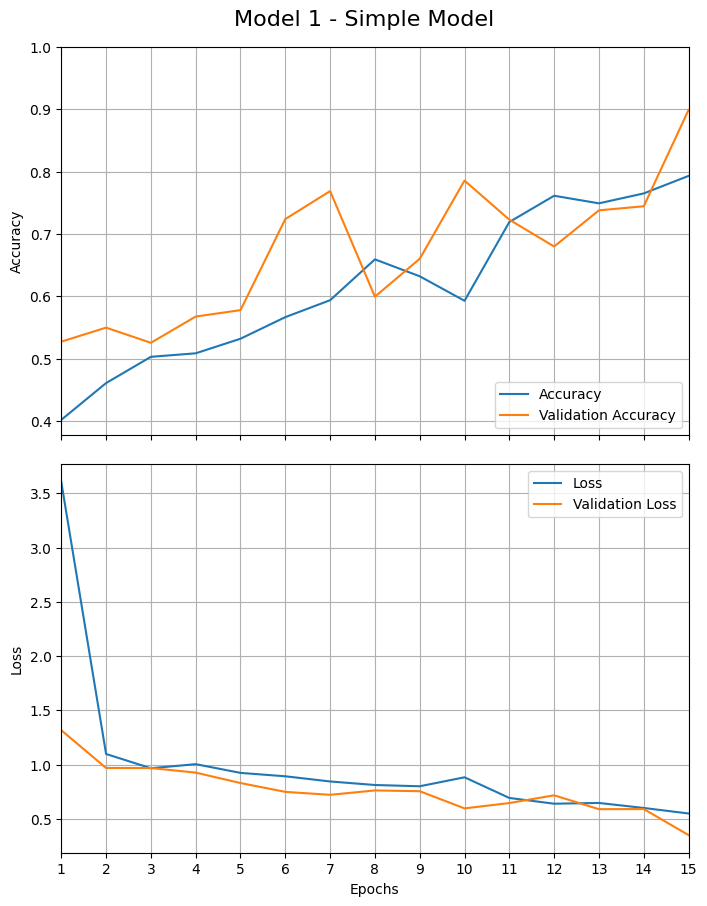

In [27]:
plot_loss_acc(history_1, "Model 1 - Simple Model")

## Model 2 - EfficientNet with random weight initialization

In [28]:
efficientnet_random = tf.keras.applications.EfficientNetB0(include_top=False, weights=None)
efficientnet_random.trainable = True
mod_2_inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name="mod_2_input_layer")
y = data_augmentation(mod_2_inputs)
y = efficientnet_random(y)
y = layers.GlobalAveragePooling2D(name="global_pool_2D")(y)
mod_2_outputs = layers.Dense(units=num_classes, activation='softmax', name='mod_2_output_layer')(y)
model_2 = tf.keras.Model(mod_2_inputs, mod_2_outputs)

In [29]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mod_2_input_layer (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_2D (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 mod_2_output_layer (Dense)  (None, 3)                 3843      
                                                           

In [30]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
history_2 = model_2.fit(train_data,
                    epochs=15,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 57s 386ms/step - loss: 1.2985 - accuracy: 0.4307 - val_loss: 1.1604 - val_accuracy: 0.3380
Epoch 2/15
34/34 [==============================] - 10s 306ms/step - loss: 0.7641 - accuracy: 0.7022 - val_loss: 4.2427 - val_accuracy: 0.3380
Epoch 3/15
34/34 [==============================] - 10s 308ms/step - loss: 0.4942 - accuracy: 0.8193 - val_loss: 5.5331 - val_accuracy: 0.3380
Epoch 4/15
34/34 [==============================] - 10s 308ms/step - loss: 0.3225 - accuracy: 0.8839 - val_loss: 5.9708 - val_accuracy: 0.3380
Epoch 5/15
34/34 [==============================] - 10s 308ms/step - loss: 0.2654 - accuracy: 0.9101 - val_loss: 6.7970 - val_accuracy: 0.3380
Epoch 6/15
34/34 [==============================] - 10s 306ms/step - loss: 0.2020 - accuracy: 0.9270 - val_loss: 8.7262 - val_accuracy: 0.3380
Epoch 7/15
34/34 [==============================] - 10s 307ms/step - loss: 0.1718 - accuracy: 0.9354 - val_loss: 7.7033 - val_accuracy: 0.3380

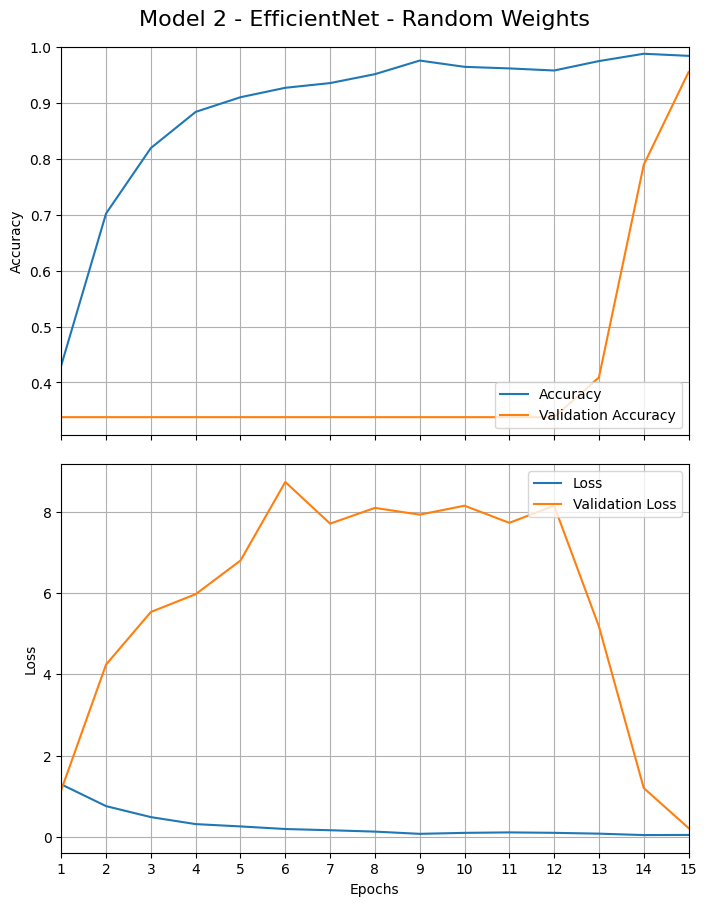

In [32]:
plot_loss_acc(history_2, "Model 2 - EfficientNet - Random Weights")

## Model 3 - EfficientNet with ImageNet weight initialization and EfficientNet layers locked

To help the model converge, and to keep consistency with Model 4 that will follow, the learning rate will be updated after 10 epochs:

1. 10 epochs with a learning rate 0.001
2. 5 epochs with a learning rate 0.0001 (to help convergence)

In [33]:
efficientnet_imnet = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
efficientnet_imnet.trainable = False
mod_3_inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name="mod_3_input_layer")
z = data_augmentation(mod_3_inputs)
z = efficientnet_imnet(z)
z = layers.GlobalAveragePooling2D(name="global_pool_2D")(z)
mod_3_outputs = layers.Dense(units=num_classes, activation='softmax', name='mod_3_output_layer')(z)
model_3 = tf.keras.Model(mod_3_inputs, mod_3_outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [34]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mod_3_input_layer (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_2D (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 mod_3_output_layer (Dense)  (None, 3)                 3843      
                                                           

In [35]:
len(model_3.layers[2].trainable_variables)

0

In [36]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [37]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:    
        return 0.0001

In [38]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [39]:
history_3 = model_3.fit(train_data,
                    epochs=15,
                    validation_data=val_data,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 13s 164ms/step - loss: 0.6679 - accuracy: 0.7800 - val_loss: 0.3166 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - 4s 122ms/step - loss: 0.3155 - accuracy: 0.9232 - val_loss: 0.1678 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - 4s 119ms/step - loss: 0.2191 - accuracy: 0.9476 - val_loss: 0.1204 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 4/15
34/34 [==============================] - 4s 119ms/step - loss: 0.1633 - accuracy: 0.9635 - val_loss: 0.0949 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 5/15
34/34 [==============================] - 5s 141ms/step - loss: 0.1488 - accuracy: 0.9710 - val_loss: 0.0785 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 6/15
34/34 [==============================] - 4s 120ms/step - loss: 0.1156 - accuracy: 0.9794 - val_loss: 0.0677 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 7/15
34/34 [==============================] - 4s 119ms/step - l

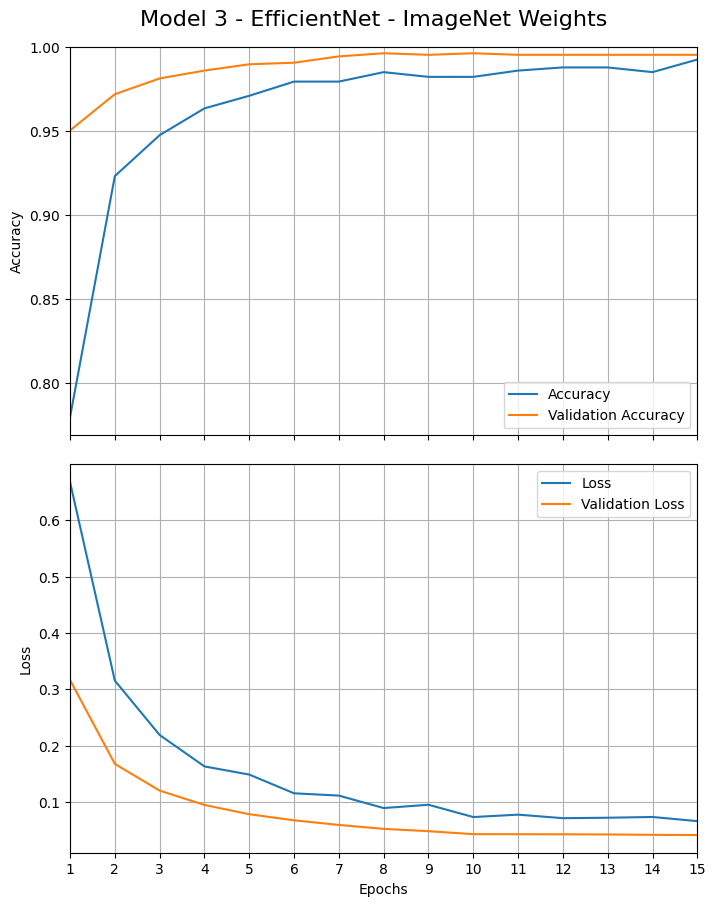

In [40]:
plot_loss_acc(history_3, "Model 3 - EfficientNet - ImageNet Weights")

## Model 4 - EfficientNet with ImageNet weight initialization and fine tuning

Model 4 is run in two parts.

1. 10 epochs with all EfficientNet layers locked - learning rate 0.001 - **Identical to Model 3**
2. 5 epochs of fine tuning with the last block (7a) of EfficientNet unlocked and learning - learning rate 0.0001 - **Fine Tuning**

In [41]:
efficientnet_imnet_fine = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
efficientnet_imnet_fine.trainable = False
mod_4_inputs = layers.Input(shape=(IMAGE_SIZE + (3,)), name="mod_4_input_layer")
zz = data_augmentation(mod_4_inputs)
zz = efficientnet_imnet_fine(zz)
zz = layers.GlobalAveragePooling2D(name="global_pool_2D")(zz)
mod_4_outputs = layers.Dense(units=num_classes, activation='softmax', name='mod_4_output_layer')(zz)
model_4 = tf.keras.Model(mod_4_inputs, mod_4_outputs)

In [42]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mod_4_input_layer (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_2D (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 mod_4_output_layer (Dense)  (None, 3)                 3843      
                                                           

In [43]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [44]:
total_epochs = 15
history_4 = model_4.fit(train_data,
                    epochs=10,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 13s 164ms/step - loss: 0.6653 - accuracy: 0.7697 - val_loss: 0.3317 - val_accuracy: 0.9466
Epoch 2/10
34/34 [==============================] - 4s 125ms/step - loss: 0.3220 - accuracy: 0.9279 - val_loss: 0.1761 - val_accuracy: 0.9775
Epoch 3/10
34/34 [==============================] - 4s 120ms/step - loss: 0.2275 - accuracy: 0.9522 - val_loss: 0.1275 - val_accuracy: 0.9822
Epoch 4/10
34/34 [==============================] - 4s 120ms/step - loss: 0.1758 - accuracy: 0.9569 - val_loss: 0.0996 - val_accuracy: 0.9860
Epoch 5/10
34/34 [==============================] - 4s 120ms/step - loss: 0.1425 - accuracy: 0.9747 - val_loss: 0.0818 - val_accuracy: 0.9888
Epoch 6/10
34/34 [==============================] - 4s 120ms/step - loss: 0.1198 - accuracy: 0.9747 - val_loss: 0.0702 - val_accuracy: 0.9906
Epoch 7/10
34/34 [==============================] - 4s 123ms/step - loss: 0.1087 - accuracy: 0.9785 - val_loss: 0.0610 - val_accuracy: 0.9934
Epoch

In [45]:
# How many layers in EfficientNetB0
len(efficientnet_imnet_fine.layers)

238

In [46]:
# Last few layers are currently locked
for layer in model_4.layers[-3].layers[-20:]:
    print(layer.name, layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv False
block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv False
block7a_project_bn False
top_conv False
top_bn False
top_activation False


In [47]:
# Unfreeze the last block of EfficientNetB0 (7a) to allow it to be trainable
efficientnet_imnet_fine.trainable = True
for layer in model_4.layers[-3].layers[:-16]:
    layer.trainable = False
for layer in model_4.layers[-3].layers[-16:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

It is worth noting that batch normalization layers should be kept frozen:

> The BatchNormalization layers need to be kept frozen ([more details](https://keras.io/guides/transfer_learning/)). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
>
> [keras.io](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

In [48]:
# check that the last block of EfficientNet is trainable
for layer in model_4.layers[-3].layers[-20:]:
    print(layer.name, layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv True
block7a_expand_bn False
block7a_expand_activation True
block7a_dwconv True
block7a_bn False
block7a_activation True
block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn False
top_conv True
top_bn False
top_activation True


In [49]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # use a finer grained learning rate to help convergence
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [50]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mod_4_input_layer (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_2D (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 mod_4_output_layer (Dense)  (None, 3)                 3843      
                                                           

In [51]:
history_4_fine = model_4.fit(train_data,
                    epochs=total_epochs,
                    initial_epoch=history_4.epoch[-1]+1, # set initial epochs to start where we left off
                    validation_data=val_data,
                    verbose=1)

Epoch 11/15
34/34 [==============================] - 15s 184ms/step - loss: 0.0518 - accuracy: 0.9869 - val_loss: 0.0256 - val_accuracy: 0.9906
Epoch 12/15
34/34 [==============================] - 4s 123ms/step - loss: 0.0300 - accuracy: 0.9925 - val_loss: 0.0101 - val_accuracy: 0.9981
Epoch 13/15
34/34 [==============================] - 4s 123ms/step - loss: 0.0155 - accuracy: 0.9972 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 14/15
34/34 [==============================] - 4s 123ms/step - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.0104 - val_accuracy: 0.9953
Epoch 15/15
34/34 [==============================] - 4s 122ms/step - loss: 0.0107 - accuracy: 0.9991 - val_loss: 0.0041 - val_accuracy: 0.9991


In [52]:
combined_history_4 = combine_histories(history_4, history_4_fine)

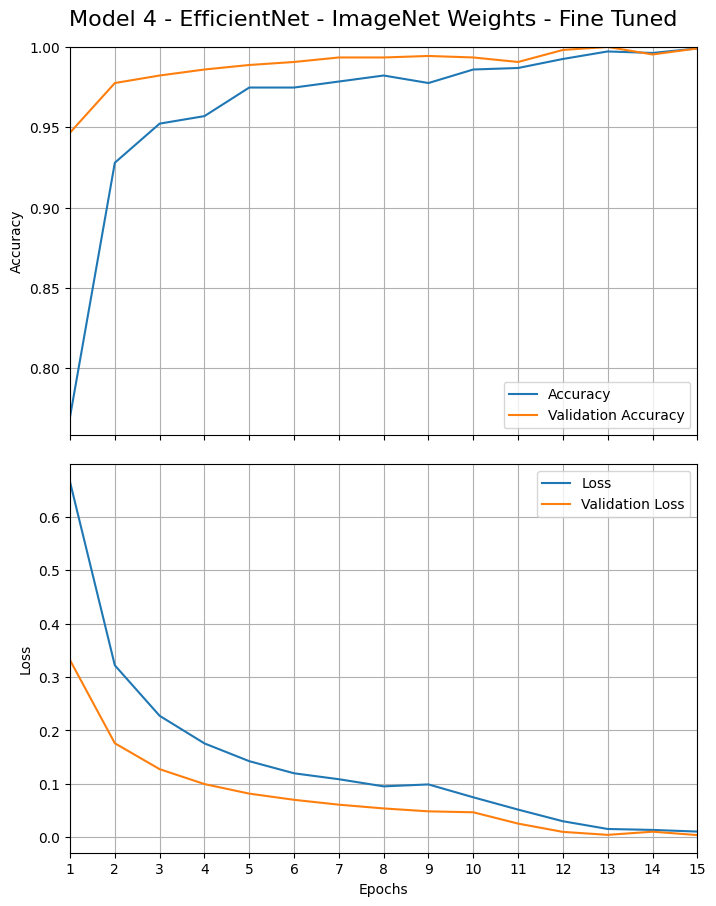

In [53]:
plot_loss_acc(combined_history_4, "Model 4 - EfficientNet - ImageNet Weights - Fine Tuned")